In [1]:
import torch
import torch.nn as nn
from torchvision import models
import torchvision.transforms as T
from torch import optim
import numpy as np
import random
from torch.autograd import Variable

import pdb
import matplotlib.pyplot as plt
import IPython.display as display
import PIL.Image
import torch.cuda.amp as amp

In [2]:
from resnet import ResNet34

In [3]:
from torchvision.datasets.cifar import CIFAR10
from torch.utils.data import Subset
from torch.utils.data import DataLoader

In [4]:
seed = 2

torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

In [5]:
device_ids = [3, 2, 0]
batch_size = len(device_ids) * 256
device = torch.device('cuda:{}'.format(device_ids[0]))

In [6]:
IMAGE_SIZE = 32
num_classes = 10

train_transform = T.Compose(
    [
        T.RandomCrop(32, padding=4),
        T.RandomHorizontalFlip(),
        T.ToTensor(),
        T.Normalize(
            (0.4914, 0.4822, 0.4465), 
            (0.2023, 0.1994, 0.2010)
        ),
    ]
)
test_transform = T.Compose(
    [
        T.ToTensor(),
        T.Normalize(
            (0.4914, 0.4822, 0.4465), 
            (0.2023, 0.1994, 0.2010)
        ),
    ]
)
train_dataset = CIFAR10(
    root="./imgs/cifar10", train=True, download=True, transform=train_transform
)
test_dataset = CIFAR10(
    root="./imgs/cifar10", train=False, download=True, transform=test_transform
)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [8]:
indices = np.random.permutation(len(train_dataset))

In [9]:
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam

c_models = []
c_optims = []
c_dsets = []
c_dloaders = []

num_clients = 2
samples_per_client = 49000

for i in range(num_clients):
    c_model = nn.DataParallel(ResNet34().to(device), device_ids=device_ids)
    c_optim = optim(c_model.parameters(), lr=3e-4)
    c_idx = indices[i*samples_per_client: (i+1)*samples_per_client]
    c_dset = Subset(train_dataset, c_idx)
    c_dloader = DataLoader(c_dset, batch_size=64*len(device_ids), shuffle=True)

    c_models.append(c_model)
    c_optims.append(c_optim)
    c_dsets.append(c_dset)
    c_dloaders.append(c_dloader)

## Isolated Training

In [47]:
total_epochs = 200
# fig, axs = plt.subplots(ncols=num_clients, nrows=1, figsize=(22, 3))

for epoch in range(total_epochs):
    for client_num in range(num_clients):
        client_num = 1
        c_model = c_models[client_num]
        c_model.eval()
        correct, total = 0, 0
        for x, y_hat in test_loader:
            with torch.no_grad():
                x, y_hat = x.to(device), y_hat.to(device)
                y = c_model(x, layer_num=0)
                correct += (y.argmax(dim=1) == y_hat).sum()
                total += x.shape[0]
        acc = correct / total
        print("epoch {}, client {}, acc {:.4f}".format(epoch, client_num, acc))
        acc_list[str(client_num)].append(acc.item())

    for client_num in range(num_clients):
        client_num = 1
        c_model = c_models[client_num]
        c_model.train()
        c_optim = c_optims[client_num]
        c_dloader = c_dloaders[client_num]
        for x, y_hat in c_dloader:
            x, y_hat = x.to(device), y_hat.to(device)
            c_optim.zero_grad()
            y = c_model(x, layer_num=0)
            loss = loss_fn(y, y_hat)
            loss.backward()
            c_optim.step()


epoch 0, client 1, acc 0.3383


NameError: name 'acc_list' is not defined

## Save models

In [12]:
for i in range(num_clients):
    torch.save(c_models[i].module.state_dict(), f"./expt_dump/c{i}_isolated.pt")

## Load models

In [11]:
for i in range(num_clients):
    c_models[i].module.load_state_dict(torch.load(f"./expt_dump/c{i}_isolated.pt"))

FileNotFoundError: [Errno 2] No such file or directory: './saved_models/c0_isolated.pt'

## Evaluate on a common test-set

In [46]:
for client_num in range(num_clients):
    c_model = c_models[client_num]
    c_model.eval()
    correct, total = 0, 0
    for x, y_hat in test_loader:
        with torch.no_grad():
            x, y_hat = x.to(device), y_hat.to(device)
            y = c_model(x)
            correct += (y.argmax(dim=1) == y_hat).sum()
            total += x.shape[0]
    print("client {}, acc {:.4f}".format(client_num, correct/total))

client 0, acc 0.9122
client 1, acc 0.3383


## Collaborative Training

In [13]:
from modules import DeepInversionFeatureHook, total_variation_loss

In [14]:
mean=np.array((0.4914, 0.4822, 0.4465))
std=np.array((0.2023, 0.1994, 0.2010))

LOWER_IMAGE_BOUND = torch.tensor((-mean / std).reshape(1, -1, 1, 1)).float().to(device)
UPPER_IMAGE_BOUND = torch.tensor(((1 - mean) / std).reshape(1, -1, 1, 1)).float().to(device)

In [15]:
def tv_loss(inputs_jit):
    diff1 = inputs_jit[:,:,:,:-1] - inputs_jit[:,:,:,1:]
    diff2 = inputs_jit[:,:,:-1,:] - inputs_jit[:,:,1:,:]
    diff3 = inputs_jit[:,:,1:,:-1] - inputs_jit[:,:,:-1,1:]
    diff4 = inputs_jit[:,:,:-1,:-1] - inputs_jit[:,:,1:,1:]
    loss_var = torch.norm(diff1) + torch.norm(diff2) + torch.norm(diff3) + torch.norm(diff4)
    return loss_var

In [63]:
def run_grad_ascent_on_data(inp, target_label, model, position,
                            img_model=None,
                            alpha_ce=1.0, alpha_f=1.0, alpha_tv=3e-5, alpha_l2=3e-8,
                            lr=3e-2, steps=2000):

    loss_r_feature_layers = []

    for module in model.modules():
        if isinstance(module, nn.BatchNorm2d):
            loss_r_feature_layers.append(DeepInversionFeatureHook(module))

    model.eval()
    loss_fn = nn.CrossEntropyLoss()
    # inp_noise = inp.detach().clone()
    updated_img = inp.detach()#.clone()
    updated_img.requires_grad = True
    updated_img.retain_grad()

    if img_model is None:
        optimizer = torch.optim.Adam([updated_img], lr=lr)
    else:
        optimizer = torch.optim.Adam(img_model.parameters(), lr=lr, eps=1e-8)
    lim_0, lim_1 = 2, 2
    for it in range(steps):
        off1 = random.randint(-lim_0, lim_0)
        off2 = random.randint(-lim_1, lim_1)
        # if img_model is not None:
        #     for n in [x for x in img_model.parameters() if len(x) == 4]:
        #         n = n + n.detach().clone().normal_()*n.std()/50
        #     updated_img = img_model(orig_img)
        inputs_jit = torch.roll(updated_img, shifts=(off1, off2), dims=(2,3))
        # inputs_jit = updated_img

        model.zero_grad()
        optimizer.zero_grad()
        acts = model.module(inputs_jit, position)
        ce_loss = loss_fn(acts, target_label)
        # ce_loss = nn.MSELoss()(acts, target_label)

        loss_r_feature = sum([model.r_feature for (idx, model) in enumerate(loss_r_feature_layers)])
        loss = alpha_ce * ce_loss + alpha_tv * tv_loss(updated_img) + alpha_l2 * torch.linalg.norm(updated_img) + alpha_f * loss_r_feature

        if it % 50 == 0:
            acc = (acts.argmax(dim=1) == target_label).sum() / acts.shape[0]
            print(f"{it}/{steps}", ce_loss.item(), loss_r_feature.item(), acc)
            # print(acts[0], target_label[0])
        loss.backward()
        optimizer.step()

        if img_model is None:
            updated_img.grad.data.zero_()
            # updated_img.data = torch.clamp(updated_img.data, min=LOWER_IMAGE_BOUND, max=UPPER_IMAGE_BOUND)

    for item in loss_r_feature_layers:
        item.close()
    # print("FINAL max_memory_reserved: %fGB"%(torch.cuda.max_memory_reserved(0)/1024/1024/1024))

    # del loss_r_feature_layers, acts, grads, inputs_jit, updated_img
    # torch.cuda.empty_cache()
    # print("AFTER memory_allocated: %fGB"%(torch.cuda.memory_allocated(0)/1024/1024/1024))
    # print("AFTER memory_reserved: %fGB"%(torch.cuda.memory_reserved(0)/1024/1024/1024))
    # print("AFTER max_memory_reserved: %fGB"%(torch.cuda.max_memory_reserved(0)/1024/1024/1024))
    # print(time.time() - start, "seconds")
    return updated_img

In [65]:
new_acc_list = {}
for i in range(num_clients):
    new_acc_list[str(i)] = []

In [66]:
new_acc_list

{'0': [], '1': []}

# Check performance improvement in collaboration

In [ ]:
bs = 256
position=0
kl_loss_fn = nn.KLDivLoss(reduction="batchmean")

fig, axs = plt.subplots(ncols=num_clients, nrows=1, figsize=(22, 3))

for epoch in range(500):
    collab_data = []
    # Evaluate on the common test set
    for client_num in range(num_clients):
        c_model = c_models[client_num]
        c_model.eval()
        correct, total = 0, 0
        for x, y_hat in test_loader:
            with torch.no_grad():
                x, y_hat = x.to(device), y_hat.to(device)
                y = c_model(x, layer_num=0)
                correct += (y.argmax(dim=1) == y_hat).sum()
                total += x.shape[0]
        acc = correct / total
        new_acc_list[str(client_num)].append(acc.item())
    print(new_acc_list)

    # Generate collab data
    for client_num in range(num_clients):
        """ We generate a zero vector of n (num_classes dimension)
        then we generate random numbers within range n and substitute
        zero at every index obtained from random number to be 1
        This way the zero vector becomes a random one-hot vector
        """
        # zeroes = torch.zeros(bs, 10)
        ind = torch.randint(low=0, high=10, size=(bs,))
        # zeroes[torch.arange(start=0, end=bs), ind] = 1
        # target = zeroes.to(device)
        target = ind.to(device)
        rand_imgs = torch.randn((bs, 3, 32, 32)).to(device)

        c_model = c_models[client_num]
        c_model.eval()
        
        updated_imgs = run_grad_ascent_on_data(rand_imgs, target, c_model, position=position,
                                               img_model=None, alpha_ce=1., steps=2000).detach()
        with torch.no_grad():
            acts = c_model(updated_imgs, position).detach()
        collab_data.append((updated_imgs, acts))
        # TODO: Only take the first client seriously for now
        break

    # Train each client on their own data and collab data
    for client_num in range(num_clients):
        c_model = c_models[client_num]
        c_model.train()
        c_optim = c_optims[client_num]
        c_dloader = c_dloaders[client_num]
        # Train it 10 times on the same distilled dataset
        for _ in range(10):
            # if client_num == 1:
            #     # we do not want client 1 to contribute for now because it wasn't trained on much data
            #     break
            for c_num, (x, y_hat) in enumerate(collab_data):
                if c_num == client_num:
                    # no need to train on its own distilled data
                    continue
                x, y_hat = x.to(device), y_hat.to(device)
                c_optim.zero_grad()
                y = c_model(x, position)
                y = nn.functional.log_softmax(y, dim=1)
                loss = kl_loss_fn(y, nn.functional.softmax(y_hat, dim=1))
                loss.backward()
                c_optim.step()
        for x, y_hat in c_dloader:
            x, y_hat = x.to(device), y_hat.to(device)
            c_optim.zero_grad()
            y = c_model(x, position)
            loss = loss_fn(y, y_hat)
            loss.backward()
            c_optim.step()
        print(f"training over {client_num}")
    # del collab_data, updated_imgs, acts


{'0': [0.9121999740600586], '1': [0.3382999897003174]}
0/2000 4.8376688957214355 19284.990234375 tensor(0.0898, device='cuda:3')
50/2000 11.996919631958008 2384.12548828125 tensor(0.1172, device='cuda:3')
100/2000 11.817474365234375 1874.72900390625 tensor(0.1094, device='cuda:3')
150/2000 11.823150634765625 2288.601318359375 tensor(0.1328, device='cuda:3')
200/2000 11.126581192016602 1965.8114013671875 tensor(0.1172, device='cuda:3')
250/2000 11.111028671264648 2168.708251953125 tensor(0.1055, device='cuda:3')
300/2000 11.280364036560059 1418.328857421875 tensor(0.1172, device='cuda:3')
350/2000 11.276748657226562 1460.3328857421875 tensor(0.0938, device='cuda:3')
400/2000 11.042470932006836 1159.742919921875 tensor(0.1211, device='cuda:3')
450/2000 11.089993476867676 1060.806396484375 tensor(0.1211, device='cuda:3')
500/2000 11.117476463317871 1193.2574462890625 tensor(0.1055, device='cuda:3')
550/2000 11.115407943725586 1303.047119140625 tensor(0.1172, device='cuda:3')
600/2000 10.6

### Test for multi-gpu speedup

In [332]:
c_models[0].module.load_state_dict(torch.load("./expt_dump/iid_clients_adaptive_collab_cifar10_2clients_2000samples_1_distill_epochs_10_steps_2000_seed1/saved_models/c0.pt"))

<All keys matched successfully>

# Deep Image Prior on the random images

In [315]:
from generative_model import skip

gen_model = skip(32, 3, num_channels_down = [16, 32, 64, 128],
                                      num_channels_up =   [16, 32, 64, 128],
                                      num_channels_skip = [0, 4, 4, 4],
                                      filter_size_down = [7, 7, 5, 5],  # type: ignore
                                      filter_size_up = [7, 7, 5, 5],   # type: ignore
                      upsample_mode='bilinear', downsample_mode='avg', need_sigmoid=True, pad='zero', act_fun='LeakyReLU')

In [61]:
bs = 256
rand_imgs = torch.randn((bs, 64, 32, 32))
zeroes = torch.zeros(bs, 10)

ind = torch.randint(low=0, high=10, size=(bs,))
# ind *= 5
# ind += 1
# zeroes[torch.arange(start=0, end=bs), ind] = 1
print(ind)

tensor([4, 0, 0, 3, 5, 0, 3, 2, 1, 8, 8, 4, 4, 8, 5, 0, 0, 9, 6, 9, 6, 2, 6, 3,
        5, 8, 0, 3, 0, 8, 3, 2, 3, 1, 8, 8, 8, 4, 8, 1, 2, 0, 0, 5, 3, 0, 4, 4,
        8, 9, 7, 8, 8, 8, 3, 8, 9, 7, 0, 0, 0, 5, 3, 2, 0, 3, 7, 9, 6, 8, 7, 8,
        2, 9, 5, 9, 9, 5, 0, 7, 8, 6, 9, 3, 1, 0, 8, 8, 8, 6, 8, 7, 4, 8, 3, 5,
        9, 4, 0, 4, 6, 3, 4, 1, 3, 8, 5, 4, 9, 1, 4, 1, 8, 9, 1, 1, 2, 7, 1, 0,
        2, 0, 1, 9, 7, 4, 3, 0, 6, 0, 2, 7, 6, 1, 8, 0, 7, 7, 4, 3, 7, 0, 3, 3,
        0, 3, 4, 1, 8, 6, 7, 0, 5, 0, 2, 4, 2, 2, 9, 7, 9, 2, 8, 4, 5, 0, 8, 7,
        7, 4, 3, 6, 2, 6, 2, 3, 1, 1, 3, 9, 8, 8, 3, 4, 1, 2, 6, 6, 1, 1, 3, 1,
        4, 9, 3, 2, 5, 5, 5, 6, 0, 6, 5, 1, 1, 4, 6, 7, 1, 7, 2, 9, 0, 9, 4, 9,
        1, 7, 1, 4, 6, 6, 5, 3, 9, 8, 5, 0, 1, 7, 7, 3, 6, 8, 8, 0, 7, 9, 0, 0,
        2, 4, 4, 4, 6, 1, 3, 4, 6, 3, 1, 6, 5, 9, 6, 5])


In [62]:
updated_imgs = run_grad_ascent_on_data(rand_imgs.to(device), ind.to(device), c_models[0], position=1,
                                       img_model=None, lr=0.1,
                                       alpha_ce=1., alpha_f=10., alpha_l2=0., alpha_tv=0.001,
                                       steps=2000)

AttributeError: 'DeepInversionFeatureHook' object has no attribute 'r_feature'

RuntimeError: CUDA error: the launch timed out and was terminated
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

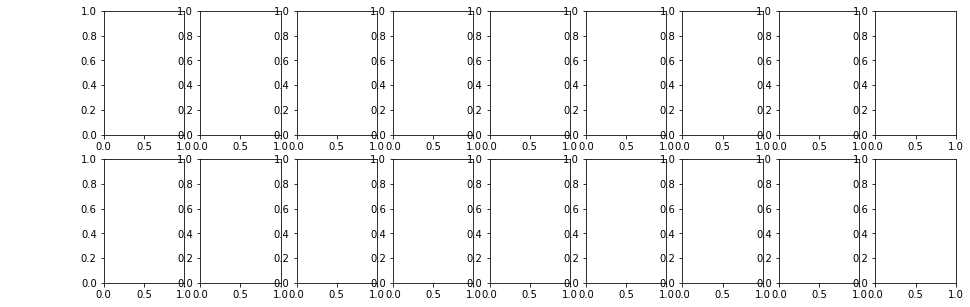

In [69]:
fig, axs = plt.subplots(ncols=10, nrows=2, figsize=(17, 5))
for i in range(10):
    axs[0][i].axis("off")
    axs[1][i].axis("off")
    # axs[2][i].axis("off")
    axs[0][i].imshow(np.array((rand_imgs[i].detach()*255).permute(1, 2, 0)[:,:,:3].cpu()).astype(np.uint8))
    # axs[1][i].imshow(np.array((img_prior[i].detach()*255).permute(1, 2, 0).cpu()).astype(np.uint8))
    axs[1][i].imshow(deprocess(updated_imgs)[i].permute(1, 2, 0).detach().cpu())

In [53]:
from torchvision import utils
utils.save_image(updated_imgs[:20].clone(),
                      './removeme1.png',
                      normalize=True, scale_each = True, nrow=10)

In [92]:
(abs(updated_imgs[0] - updated_imgs[1])).max()

tensor(0.0067, device='cuda:0', grad_fn=<MaxBackward1>)

In [48]:
# Normalize an image
def deprocess(img):
    inv_normalize = T.Normalize(
       mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
       std=[1/0.229, 1/0.224, 1/0.225]
    )
    img = inv_normalize(img)
    img = 255*img
    return img.type(torch.uint8)

In [93]:
c_models[0](rand_imgs)[:,:10]

tensor([[ -6.2234,  -6.3234, -26.0120, -25.0174,  -3.9302,  -6.2938, -26.3084,
         -26.1992, -25.7642, -25.9508],
        [ -4.4034,  -3.2350, -21.4144, -20.0738,  -4.0045,  -4.0403, -19.8059,
         -20.7658, -21.2401, -20.8493],
        [ -5.8798,  -4.2963, -27.7720, -25.6363,  -6.0319,  -4.6734, -25.3708,
         -26.5396, -26.8712, -26.6936],
        [-12.5551,  -6.1844, -40.4543, -40.2059, -10.9165, -12.7064, -39.0421,
         -39.0891, -40.4680, -40.0667],
        [ -5.9261,  -3.7569, -27.0156, -25.1447,  -5.3495,  -5.1784, -24.8002,
         -25.9212, -26.3600, -25.9734],
        [ -8.8144, -13.4271, -34.4055, -33.2453,  -3.5201,  -9.0524, -35.1161,
         -34.4815, -34.2569, -34.5227],
        [ -4.7298,  -3.2915, -20.1200, -18.4321,  -2.6959,  -4.0940, -18.3464,
         -19.4940, -19.7146, -19.5202],
        [ -5.9741,  -4.1775, -23.3758, -22.1293,  -3.1037,  -5.5536, -23.1064,
         -23.3743, -23.2530, -23.2161],
        [ -6.0474,  -6.0017, -24.0202, -22.8700,

In [181]:
zeroes.argmax(dim=1)

tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

In [56]:
c_models[0].eval()
correct, total = 0, 0
for x, y_hat in test_loader:
    with torch.no_grad():
        x, y_hat = x.to(device), y_hat.to(device)
        y = c_models[0](x)
        correct += (y.argmax(dim=1) == y_hat).sum()
        total += x.shape[0]
        print(y.argmax(dim=1), y_hat)
print("client {}, acc {:.4f}".format(client_num, correct/total))

tensor([5, 0, 0,  ..., 0, 0, 0], device='cuda:0') tensor([3, 8, 8,  ..., 1, 0, 0], device='cuda:0')
tensor([5, 5, 0,  ..., 0, 5, 5], device='cuda:0') tensor([3, 5, 0,  ..., 1, 3, 5], device='cuda:0')
tensor([0, 5, 0,  ..., 0, 0, 5], device='cuda:0') tensor([8, 3, 8,  ..., 4, 0, 7], device='cuda:0')
tensor([0, 5, 0,  ..., 5, 5, 0], device='cuda:0') tensor([8, 3, 1,  ..., 3, 3, 8], device='cuda:0')
tensor([0, 5, 0,  ..., 5, 0, 5], device='cuda:0') tensor([8, 3, 9,  ..., 7, 2, 5], device='cuda:0')
tensor([0, 5, 5,  ..., 0, 5, 5], device='cuda:0') tensor([9, 6, 6,  ..., 8, 5, 9], device='cuda:0')
tensor([5, 5, 0,  ..., 0, 5, 5], device='cuda:0') tensor([7, 2, 0,  ..., 0, 1, 7], device='cuda:0')
tensor([5, 0, 0,  ..., 0, 5, 5], device='cuda:0') tensor([5, 1, 9,  ..., 8, 4, 6], device='cuda:0')
tensor([5, 5, 0,  ..., 5, 5, 5], device='cuda:0') tensor([5, 3, 1,  ..., 2, 9, 5], device='cuda:0')
tensor([5, 0, 5, 5, 0, 5, 0, 5, 5, 0, 5, 0, 5, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 5, 5, 5, 